# Generate voxel masks along TRA axis

The idea is to get slice10 for example, and then intersect it with transverse slices across L=0 to L=1 in N pieces.

Then get exc cells in this subslice and get their postsynaptic exc cells and their positions

For each neuron in subslice 1, get mean of pos of its exc targets as a vector. you can also average these vectors again to get subslice vector of propagation

## Import necessary libraries and variables

In [1]:
import voxcell
from voxcell import CellCollection, VoxelData, RegionMap
# from brainbuilder.utils import bbp
import numpy as np
import requests
from matplotlib import cm
import matplotlib
import pandas as pd
import numpy.linalg as la
from bluepy.enums import Cell
from bluepy import Circuit
from bluepy.geometry.roi import Cube
from coordinate_query import CoordinateQuery, query_enriched_positions, LON, TRA, RAD
import math
from log_progress import log_progress
from pathlib import Path
from voxcell.nexus.voxelbrain import Atlas
from bluepy import Circuit
from coordinate_query import CoordinateQuery, enriched_cells_positions, query_enriched_positions, LON, TRA, RAD
from log_progress import log_progress

In [2]:
circ_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/CircuitConfig'
slice_thickness = 400 # um
usertarget_path = f'slices{slice_thickness}.target'
circuit = Circuit(circ_path)

ATLAS_DIR = Path("/gpfs/bbp.cscs.ch/project/proj112/entities/atlas/20211004_BioM/")
CIRCUIT_DIR = Path('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/')
c = Circuit((CIRCUIT_DIR / 'CircuitConfig').as_posix())
atlas = Atlas.open(ATLAS_DIR.as_posix())
orientation = atlas.load_data("orientation")

In [3]:
def update_user_target(filename, gids, target_name, notes):
    with open(filename, 'a') as f:
        f.write(notes)
        f.write('\nTarget Cell %s\n{' % target_name)
        f.write(' '.join(['a%d' % gid for gid in gids]))
        f.write('}\n\n')

def get_gids_in_voxel(mask,circuit):
    in_target = mask.lookup(circuit.cells.get(properties=list("xyz")).values)
    gids_in_target = circuit.cells.get().index.values[np.where(in_target==1)]
    return gids_in_target

In [128]:
CIRCUIT_DIR.parent.as_posix()

'/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1'

In [4]:
# load the atlas in the coordinatequery
file_path = '/gpfs/bbp.cscs.ch/project/proj112/entities/atlas/20211004_BioM/coordinates.nrrd'
from coordinate_query import CoordinateQuery, query_enriched_positions, LON, TRA, RAD

q = CoordinateQuery(file_path)
# Enriched your ltr positions in the positions df from bluepy
xyz_ltr = enriched_cells_positions(circuit, q)

## Generate TRA slices

In [5]:
t_min,t_max= 0,0.1
tra_slice_mask = q._get_range_mask(min_value=t_min, max_value=t_max, axis=TRA)

In [6]:
tra_dt = 0.1
tra_slices = np.arange(0,1,tra_dt)
for idx, tra_min in enumerate(log_progress(tra_slices, every=1)):
    tra_max = tra_min + tra_dt
    cur_slice_mask = q._get_range_mask(min_value=tra_min, max_value=tra_max, axis=TRA)
    orientation.with_data(np.asarray(cur_slice_mask, dtype=np.uint8)).save_nrrd(f"tra_masks/slice_tra__{idx+1}__{len(tra_slices)}.nrrd")


## Intersect with LON slices and get soma positons

In [5]:
volumetric_slices_LON = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/scripts/5_slice_generation/nrrd_masks_serially_generated_but_not_used/'

In [6]:
import os
from voxcell import VoxelData

In [7]:
num_lon_slices = len(os.listdir(volumetric_slices_LON))
num_lon_slices

35

In [125]:
# intersect LON slices with TRA slice
for lon_slice_idx in np.arange(1,num_lon_slices+1):
    if lon_slice_idx not in [10]:
        continue # skip for now except for 3

    for tra_slice_idx in np.arange(1,len(tra_slices)+1):
        tra_slice = VoxelData.load_nrrd(f'tra_masks/slice_tra__{tra_slice_idx}__10.nrrd')
        lon_slice = VoxelData.load_nrrd(f'{volumetric_slices_LON}/slice400_{lon_slice_idx}.nrrd')
        print(f'tra_slice: {tra_slice_idx} | lon_slice: {lon_slice_idx}')
        
        interseciton_slice = tra_slice.raw & lon_slice.raw
        print(f"lon_tra_intersection_masks/slice_LON_{lon_slice_idx}_TRA_{tra_slice_idx}.nrrd")
        orientation.with_data(np.asarray(interseciton_slice, dtype=np.uint8)).save_nrrd(f"lon_tra_intersection_masks/slice_LON_{lon_slice_idx}_TRA_{tra_slice_idx}.nrrd")

tra_slice: 1 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_1.nrrd
tra_slice: 2 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_2.nrrd
tra_slice: 3 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_3.nrrd
tra_slice: 4 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_4.nrrd
tra_slice: 5 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_5.nrrd
tra_slice: 6 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_6.nrrd
tra_slice: 7 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_7.nrrd
tra_slice: 8 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_8.nrrd
tra_slice: 9 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_9.nrrd
tra_slice: 10 | lon_slice: 10
lon_tra_intersection_masks/slice_LON_10_TRA_10.nrrd


## get synapses from slice idx to idx+1

In [10]:
int_mask = Atlas.open('lon_tra_intersection_masks').load_data('slice_LON_10_TRA_1')
mask_gids = get_gids_in_voxel(int_mask,c)

In [11]:
print(f'There are {len(mask_gids)} cells in this mask')

There are 1323 cells in this mask


In [12]:
c.cells.ids('SP_PC')

array([  1672,   1673,   1674, ..., 408335, 408336, 408337])

In [13]:
exc_mask_gids = np.intersect1d(mask_gids,c.cells.ids('SP_PC'))
print(f'There are {len(exc_mask_gids)} SP_PC cells in this mask')

There are 1179 SP_PC cells in this mask


In [42]:
lon_i = 10

exc_dict = {}
for tra_i in np.arange(1,11,1):
    int_mask = Atlas.open('lon_tra_intersection_masks').load_data(f'slice_LON_{lon_i}_TRA_{tra_i}')
    mask_gids = get_gids_in_voxel(int_mask,c)
    exc_mask_gids = np.intersect1d(mask_gids,c.cells.ids('SP_PC'))
    print(f'There are {len(exc_mask_gids)}/{len(mask_gids)} SP_PC cells in slice {lon_i}.{tra_i}')
    exc_dict[f'{lon_i}.{tra_i}'] = exc_mask_gids

There are 1179/1323 SP_PC cells in slice 10.1
There are 1476/1654 SP_PC cells in slice 10.2
There are 1660/1829 SP_PC cells in slice 10.3
There are 1510/1672 SP_PC cells in slice 10.4
There are 1533/1736 SP_PC cells in slice 10.5
There are 1765/1954 SP_PC cells in slice 10.6
There are 1833/2066 SP_PC cells in slice 10.7
There are 1700/1920 SP_PC cells in slice 10.8
There are 1666/1872 SP_PC cells in slice 10.9
There are 908/1018 SP_PC cells in slice 10.10


In [43]:
exc_dict

{'10.1': array([  2094,   2539,   2832, ..., 406507, 406599, 407648]),
 '10.2': array([  2017,   2459,   2606, ..., 407140, 407398, 407407]),
 '10.3': array([  1871,   2139,   2169, ..., 407487, 407970, 408123]),
 '10.4': array([  1705,   2395,   2409, ..., 407647, 407782, 407842]),
 '10.5': array([  1892,   2003,   2058, ..., 408134, 408215, 408245]),
 '10.6': array([  1717,   2326,   2520, ..., 407927, 407948, 408215]),
 '10.7': array([  2145,   2146,   2315, ..., 407454, 407973, 407974]),
 '10.8': array([  1789,   1968,   2212, ..., 407751, 408158, 408319]),
 '10.9': array([  1693,   1953,   2043, ..., 406778, 407187, 408160]),
 '10.10': array([  1827,   2133,   2235,   2504,   2531,   2818,   2910,   3258,
          3303,   5094,   5220,   5359,   6030,   6463,   6490,   6575,
          6657,   9337,  10435,  11158,  11239,  11258,  11849,  12102,
         12600,  12990,  13810,  13882,  13956,  14795,  14875,  14990,
         15411,  16929,  17146,  17369,  17620,  17918,  19496, 

In [10]:
#synapse counts from proximal to distal as a measure of information flow
lon_i = 10
tra_i_pre = 1

tra_dict = {}
for i in range(1,10):
    pathway_syns = c.connectome.pathway_synapses(pre=exc_dict[f'{lon_i}.{tra_i_pre}'],
                                                 post=exc_dict[f'{lon_i}.{i}'])
    print(len(pathway_syns))
    tra_dict[f'{lon_i}.{tra_i_pre}_{i}'] = len(pathway_syns)

37828
37624
62213
48361
10705
201
0
0
0


In [11]:
import matplotlib.pyplot as plt

In [15]:
# also get this information from adj matrix
from scipy import sparse

adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
adj = sparse.load_npz(adj_path)

In [47]:
#synapse counts from proximal to distal as a measure of information flow
lon_i = 10
tra_i_pre = 1

tra_dict_adj = {}
for i in range(1,11):
    pre_indices = exc_dict[f'{lon_i}.{tra_i_pre}']-1
    post_indices = exc_dict[f'{lon_i}.{i}']-1
    temp = adj[pre_indices]
    temp = temp[:,post_indices]
    num_syns = int(temp.sum())
    tra_dict_adj[f'{lon_i}.{tra_i_pre}_{i}'] = num_syns

In [55]:
#synapse counts from proximal to distal as a measure of information flow
lon_i = 10
target_slices = range(1,11)
tra_df = pd.DataFrame()
tra_df = tra_df.rename_axis('Transverse_Slice_Pre')
for tra_idx_pre in target_slices:
    for tra_idx_post in target_slices:
        pre_indices = exc_dict[f'{lon_i}.{tra_idx_pre}']-1
        post_indices = exc_dict[f'{lon_i}.{tra_idx_post}']-1
        temp = adj[pre_indices]
        temp = temp[:,post_indices]
        num_syns = int(temp.sum())
        tra_df.loc[tra_idx_pre,tra_idx_post] = num_syns

In [56]:
tra_df

,1,2,3,4,5,6,7,8,9,10
Transverse_Slice_Pre,,,,,,,,,,
1,37828.0,37624.0,62213.0,48361.0,10705.0,201.0,0.0,0.0,0.0,0.0
2,44999.0,69763.0,26884.0,24782.0,12566.0,3587.0,88.0,0.0,0.0,0.0
3,29303.0,103095.0,93537.0,12866.0,3064.0,2586.0,906.0,9.0,0.0,0.0
4,948.0,27235.0,108474.0,84473.0,4436.0,359.0,425.0,82.0,0.0,0.0
5,0.0,179.0,18513.0,96712.0,92433.0,9827.0,515.0,30.0,1.0,0.0
6,0.0,0.0,83.0,18904.0,126204.0,115339.0,11920.0,61.0,1.0,0.0
7,0.0,0.0,1.0,269.0,37391.0,161156.0,168472.0,8112.0,0.0,0.0
8,0.0,0.0,0.0,0.0,523.0,28936.0,165712.0,186159.0,8521.0,4.0
9,0.0,0.0,0.0,0.0,0.0,58.0,6193.0,158328.0,177660.0,7104.0


In [124]:
import seaborn as sns

<Axes: ylabel='Transverse_Slice_Pre'>

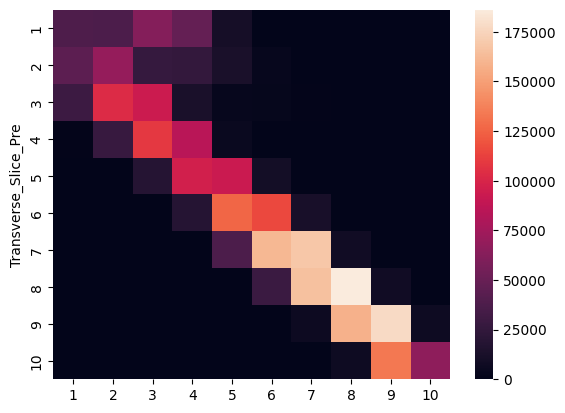

In [125]:
sns.heatmap(tra_df)

In [110]:
for tra_idx_post in target_slices:
    print(f"{tra_idx_post}: {len(exc_dict[f'{lon_i}.{tra_idx_post}']-1)}")
        

1: 1179
2: 1476
3: 1660
4: 1510
5: 1533
6: 1765
7: 1833
8: 1700
9: 1666
10: 908


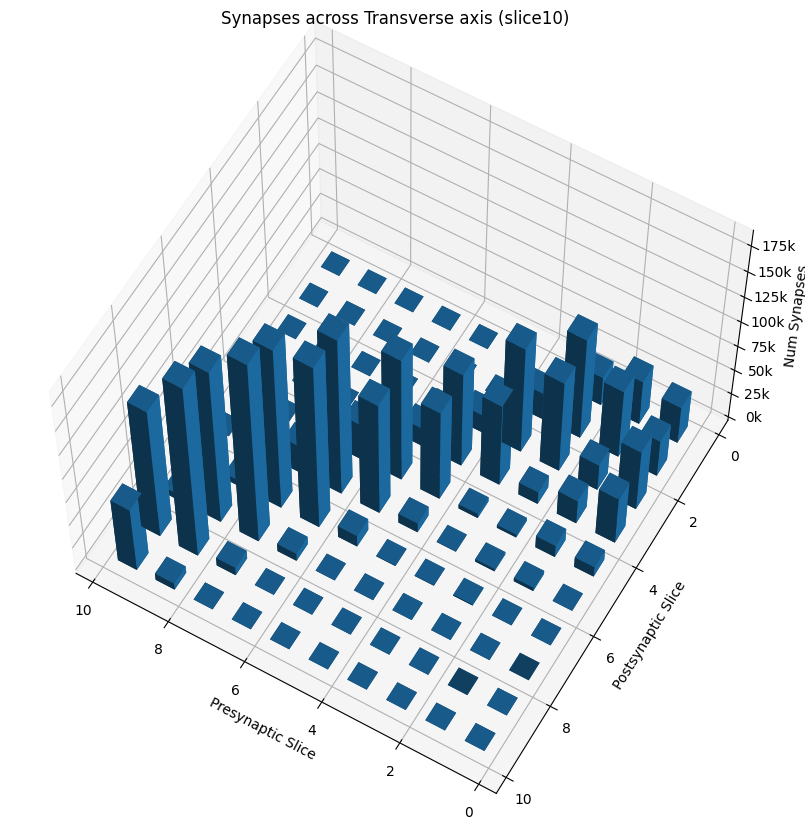

In [112]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
_, xedges, yedges = np.histogram2d(x, y, bins=10, range=[[0, 10], [0, 10]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = tra_df.values.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(elev=60, azim=120)  # Adjust the elevation (vertical angle) and azimuth (horizontal angle)
ax.set_xlabel('Presynaptic Slice')
ax.set_ylabel('Postsynaptic Slice')
ax.set_zlabel('Num Synapses')
# Move the z-axis label to the bottom edge
ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

plt.title('Synapses across Transverse axis (slice10)')
plt.show()

Text(0, 0.5, 'Number of Synapses')

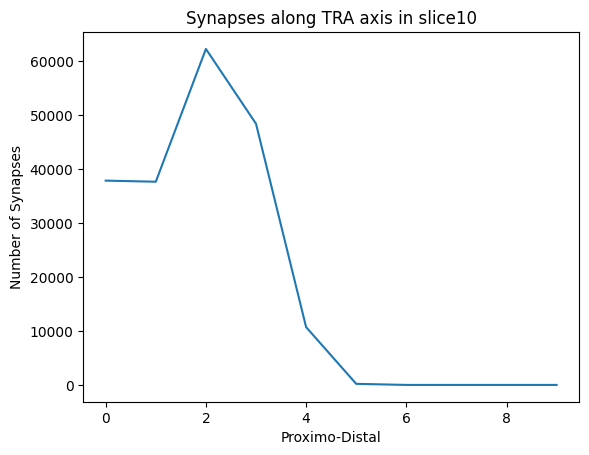

In [52]:
plt.plot(tra_dict_adj.values())
plt.title(f'Synapses along TRA axis in slice{lon_i}')
plt.xlabel('Proximo-Distal')
plt.ylabel('Number of Synapses')